## 2.4. Pyro の概要

$$
\begin{align*}
    \theta &\sim \text{Beta}(\theta | \alpha, \beta) \\
    y_n | \theta &\sim \text{Bern}(y_n | \theta), \ n = 1, \dots, N
\end{align*}
$$

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import torch
from torch.distributions import constraints
import pyro

sns.set()

/Users/yuta.sonoda/opt/anaconda3/envs/bayes_ml/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
from torch.distributions import constraints

In [3]:
# 観測データ
y = torch.tensor([1, 0, 0, 1, 1, 1, 0, 1, 1, 0], dtype=torch.float)

In [4]:
# モデルの定義
def model(y):
    # 事前分布のパラメータ
    alpha = torch.tensor(1.0)
    beta = torch.tensor(1.0)

    # 推論対象とするパラメータの事前分布
    theta = pyro.sample("theta", pyro.distributions.Beta(alpha, beta))

    # 観測データの数だけ独立に生成
    with pyro.plate("sample", len(y)):
        # 尤度関数
        pyro.sample("obs", pyro.distributions.Bernoulli(theta), obs=y)

In [5]:
# 近似分布の定義
def guide(y):
    # 最適化する変分パラメータ (正に制約)
    alpha_q = pyro.param("alpha_q", torch.tensor(5.0), constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(5.0), constraint=constraints.positive)

    # 近似分布にベータ分布を仮定
    pred_p = pyro.sample("theta", pyro.distributions.Beta(alpha_q, beta_q))
    return pred_p

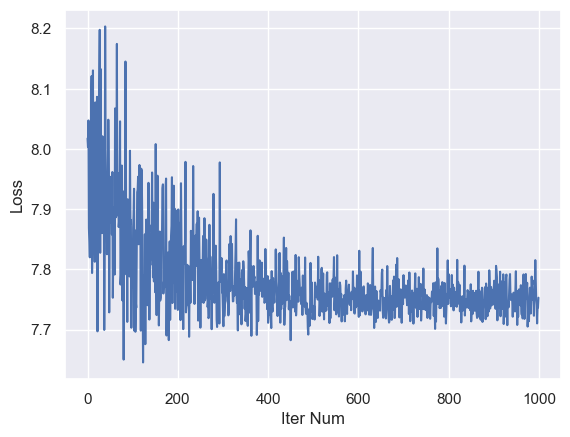

In [6]:
# グローバル変数として格納されているパラメータを初期化
pyro.clear_param_store()

# optimizer の設定
optimizer = pyro.optim.Adam({"lr": 0.0005})

# SVI の設定 (ELBO 計算に使う近似分布からのサンプル数を 30 に設定)
svi = pyro.infer.SVI(model, guide, optimizer, loss=pyro.infer.Trace_ELBO(num_particles=30))

# 最適化ループ
loss_list = []
for step in range(1000):
    loss = svi.step(y)
    loss_list.append(loss)

plt.plot(loss_list)
plt.xlabel("Iter Num")
plt.ylabel("Loss")
plt.show()

In [7]:
# グローバル変数として管理されているパラメータを確認
for para_name in pyro.get_param_store():
    print(para_name)

alpha_q
beta_q


In [8]:
# 近似分布の平均と標準偏差
alpha_q = pyro.param("alpha_q").detach().numpy()
beta_q = pyro.param("beta_q").detach().numpy()
variational_posterior = stats.beta(float(alpha_q), float(beta_q))
print("variational posterior mean: {:.3f}".format(variational_posterior.mean()))
print("variational posterior std: {:.3f}".format(variational_posterior.std()))

# 真の事後分布の平均と標準偏差
alpha_t = 1 + torch.sum(y)
beta_t = 1 + 10 - torch.sum(y)
true_posterior = stats.beta(float(alpha_t), float(beta_t))
print("true posterior mean: {:.3f}".format(true_posterior.mean()))
print("ture posterior std: {:.3f}".format(true_posterior.std()))

variational posterior mean: 0.580
variational posterior std: 0.146
true posterior mean: 0.583
ture posterior std: 0.137


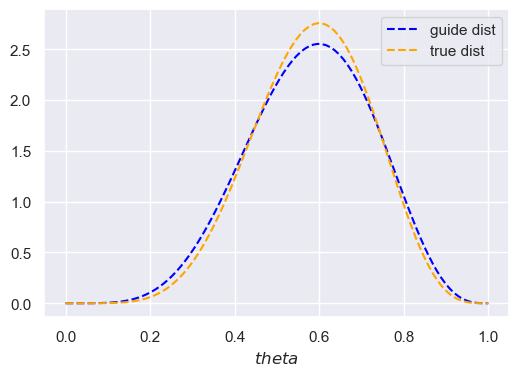

In [9]:
x_lin = np.linspace(0.0, 1.0, 100)
fig, ax = plt.subplots(figsize=(6, 4))

# 近似分布
ax.plot(x_lin, variational_posterior.pdf(x_lin), ls="--", color="blue", label="guide dist")

# 真の事後分布
ax.plot(x_lin, true_posterior.pdf(x_lin), ls="--", color="orange", label="true dist")
ax.legend()
ax.set_xlabel("$theta$")
plt.show()